In [16]:
import os 
# dirs = [ os.path.join(os.path.abspath("./") , x) for x in os.listdir() if os.path.isdir(x) and "Zn" in x]
# ex =  dirs[0]
# infile = [ os.path.join(ex , x) for x in os.listdir(ex) if "Zn" in x ][0]
# infile

## 3차원 구 방식

In [20]:
import os
import numpy as np

# 설정: 원자 파일 이름과 흡착체-금속 거리 기준 (단위: Å)
input_file = "Zn101_2x2x2_primitive_14A_vaccum_relax.in"
output_file = os.path.join("./", "Zn101_2x2x2_primitive_14A_vaccum_relax_fix.in")

adsorption_center = np.array([1.098737, 1.415163, 3.77350])  # 흡착 분자의 중심 좌표
relax_radius = 113.0  # Relax할 반경 (XY 평면에서의 거리 기준)
c_limit = 2.0  # C축(Z 방향)으로 이 값 이상이면 Relax하지 않음

# 파일 읽기
with open(input_file, "r") as f:
    lines = f.readlines()

output_lines = []
for line in lines:
    split_line = line.strip().split()
    if len(split_line) == 4:  # 원자 정보가 있는 줄만 처리
        element, x, y, z = split_line
        coords = np.array([float(x), float(y), float(z)])
        xy_distance = np.linalg.norm(coords[:2] - adsorption_center[:2])  # XY 평면 거리 계산
        z_distance = abs(coords[2] - adsorption_center[2])  # Z 방향 거리 계산

        # Relax 조건 적용:
        # 1) XY 평면에서 relax_radius 이내
        # 2) Z 방향에서 c_limit 이내
        if xy_distance <= relax_radius and z_distance <= c_limit:
            output_lines.append(f"{element}  {x}  {y}  {z}  1  1  1\n")
        else:
            output_lines.append(f"{element}  {x}  {y}  {z}  0  0  0\n")

# 새로운 파일로 저장
with open(output_file, "w") as f:
    f.writelines(output_lines)

print(f"✅ 완료! 새로운 파일 {output_file}이(가) 생성되었습니다.")


✅ 완료! 새로운 파일 ./Zn101_2x2x2_primitive_14A_vaccum_relax_fix.in이(가) 생성되었습니다.


## 고정된 분자 시각화 matplotlib

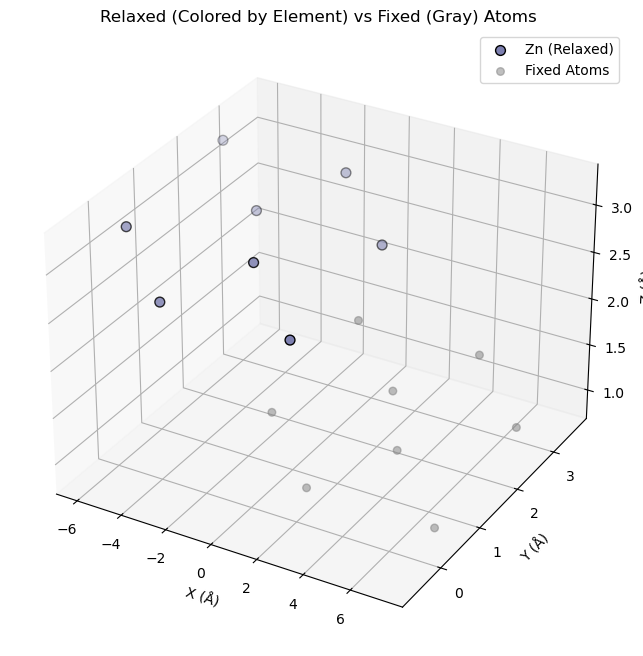

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import json

# 원소 색상 파일 불러오기
with open("element_colors.json", "r") as f:
    element_colors = json.load(f)

# ATOMIC_POSITIONS 파일 입력
input_file = output_file

# 원자 데이터 저장 리스트
elements = []
coordinates = []
relax_flags = []

# 파일 읽기
with open(input_file, "r") as f:
    lines = f.readlines()

for line in lines:
    split_line = line.strip().split()
    if len(split_line) == 7:  # 원자 정보가 있는 줄만 처리
        element, x, y, z, rx, ry, rz = split_line
        coordinates.append([float(x), float(y), float(z)])
        elements.append(element)
        relax_flags.append((int(rx), int(ry), int(rz)))

# NumPy 배열 변환
coordinates = np.array(coordinates)
relax_flags = np.array(relax_flags)

# Relax 여부 판단 (1 1 1 인 경우 색깔 변경)
is_relaxed = np.all(relax_flags == (1, 1, 1), axis=1)

# 플롯 생성
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Relaxed 원자 (원소별 색상 적용)
for element in set(elements):  # 중복 없이 원소 리스트 추출
    element_mask = (np.array(elements) == element) & is_relaxed  # 해당 원소 & Relax된 원자만 선택
    if np.any(element_mask):  # 존재하는 경우만 추가
        ax.scatter(coordinates[element_mask, 0], coordinates[element_mask, 1], coordinates[element_mask, 2],
                   color=element_colors.get(element, "black"), label=f"{element} (Relaxed)", s=50, edgecolors='k')

# Fixed 원자 (회색)
ax.scatter(coordinates[~is_relaxed, 0], coordinates[~is_relaxed, 1], coordinates[~is_relaxed, 2], 
           color='gray', label="Fixed Atoms", s=30, alpha=0.5)

# 라벨 및 스타일 설정
ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.legend()
plt.title("Relaxed (Colored by Element) vs Fixed (Gray) Atoms")

# 그래프 출력
plt.show()


In [22]:
import numpy as np
import plotly.graph_objects as go
import json

# ATOMIC_POSITIONS 파일 입력
input_file = output_file

# 원소 색상 파일 불러오기
with open("element_colors.json", "r") as f:
    element_colors = json.load(f)

# 원자 데이터 저장 리스트
elements = []
coordinates = []
relax_flags = []

# 파일 읽기
with open(input_file, "r") as f:
    lines = f.readlines()

for line in lines:
    split_line = line.strip().split()
    
    # 7개 값이 있어야 정상적인 원자 데이터로 간주
    if len(split_line) == 7:
        element, x, y, z, rx, ry, rz = split_line
        coordinates.append([float(x), float(y), float(z)])
        elements.append(element)
        relax_flags.append([int(rx), int(ry), int(rz)])

# numpy 배열 변환
coordinates = np.array(coordinates)
relax_flags = np.array(relax_flags)

# Relax 여부 판단 (모든 좌표에서 1 1 1인 경우 Relax로 분류)
is_relaxed = np.all(relax_flags == [1,1, 1], axis=1)

# 3D 시각화
fig = go.Figure()

# Relaxed 원자 (원소별 색상)
for element in set(elements):  # 중복 없이 원소 리스트 추출
    element_mask = (np.array(elements) == element) & is_relaxed  # 해당 원소 & Relax된 원자만 선택
    if np.any(element_mask):  # 존재하는 경우만 추가
        fig.add_trace(go.Scatter3d(
            x=coordinates[element_mask, 0],
            y=coordinates[element_mask, 1],
            z=coordinates[element_mask, 2],
            mode='markers',
            marker=dict(size=6, color=element_colors.get(element, "black"), opacity=1.0),
            name=f"{element} (Relaxed)"
        ))

# Fixed 원자 (회색)
fig.add_trace(go.Scatter3d(
    x=coordinates[~is_relaxed, 0], 
    y=coordinates[~is_relaxed, 1], 
    z=coordinates[~is_relaxed, 2],
    mode='markers', marker=dict(size=5, color='gray', opacity=0.5),
    name="Fixed Atoms"
))

# 3D 레이아웃 설정
fig.update_layout(
    title="Interactive 3D Atom Visualization (Color by Element)",
    scene=dict(
        xaxis_title="X (Å)",
        yaxis_title="Y (Å)",
        zaxis_title="Z (Å)",
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    height=700
)

# 인터랙티브 플롯 출력
fig.show()


In [12]:
relax_flags

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [23]:
import plotly
print(plotly.__version__)


5.24.1
